# Import packages

In [1]:
import torch
import pynncml as pnc
import numpy as np
from matplotlib import pyplot as plt
import opensense_data_downloader_and_transformer as oddt

C:\Users\haih\Anaconda3\envs\opensense\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download Dataset 
This is a generic code that download and preprocess the OpenMRG dataset.

In [2]:
oddt.download_andersson_2022_OpenMRG(local_path='data/andersson_2022_OpenMRG/', print_output=True)
ds = oddt.transform_andersson_2022_OpenMRG(
    fn='data/andersson_2022_OpenMRG/OpenMRG.zip', 
    path_to_extract_to='data/andersson_2022_OpenMRG/',
)

Creating path data/andersson_2022_OpenMRG/
to data/andersson_2022_OpenMRG//OpenMRG.zip


# Transform Dataset to PyNNcml format
In this part of the code, we transform the OpenMRG dataset into PyNNcml format. In addition, we generate a Min-Max 15 minutes data from TSL and RSL  every  10sec sample to illustrate the use of some algorithms inside PyNNcml.

In [5]:
sublink_index=0
ds_sublink=ds.isel(sublink=sublink_index)
# frequency, polarization, length, height_far, height_near
meta_data=pnc.MetaData(float(ds_sublink.frequency),
                   bool(ds_sublink.polarization!='Vertical'), # Vertical 1
                   float(ds_sublink.length),
                   25,
                   25)
rsl_array=np.asarray(ds_sublink.tsl)
tsl_array=np.asarray(ds_sublink.rsl)
time_array=np.asarray(ds_sublink.time).astype('datetime64[s]').astype("int")
link_data=pnc.Link(rsl_array,
                   np.zeros(time_array.shape[0]), # Insert zero instade of rain rate values.
                   time_array,
                   meta_data,
                   tsl_array)
link_min_max=link_data.create_min_max_link(300)
att=link_min_max.attenuation().T
att=torch.unsqueeze(att,dim=0)

# Running Dynamic Baseline +Power Law
In the following line of code: we run a dynamic baseline algorithm [1] which is followed by calibrated min-max power-law [2].

In [6]:
osd = pnc.rain_estimation.one_step_dynamic_baseline(pnc.power_law.PowerLawType.MAX,1.2,8) # init classification model
rain = osd(att,link_min_max.meta_data) # run Dynamic method

# Plot
Here, we plot the rain estimation and sub-link min-max attenuation 

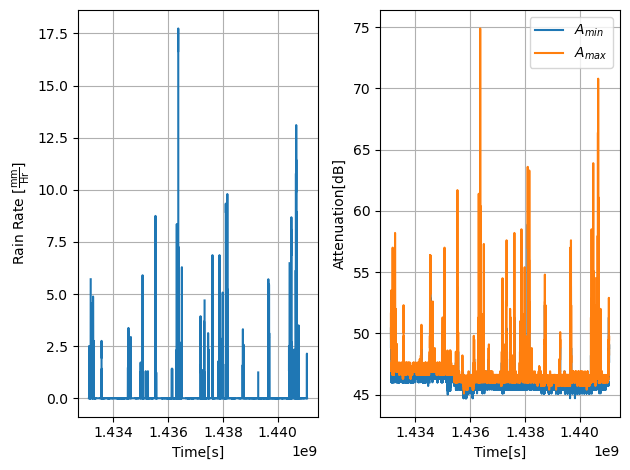

In [17]:

plt.subplot(1,2,1)
plt.plot(link_min_max.time_array,rain[0,:].numpy())
plt.xlabel("Time[s]")
plt.ylabel(r"Rain Rate $[\frac{\mathrm{mm}}{\mathrm{Hr}}]$")
plt.grid()
plt.subplot(1,2,2)
plt.plot(link_min_max.time_array,-att[0,:,0].numpy(),label=r"$A_{min}$")
plt.plot(link_min_max.time_array,-att[0,:,1].numpy(),label=r"$A_{max}$")
plt.xlabel("Time[s]")
plt.ylabel("Attenuation[dB]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# plt.plot(wd)

# References 

[1] Ostrometzky, Jonatan, and Hagit Messer. "Dynamic determination of the baseline level in microwave links for rain monitoring from minimum attenuation values." IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing 11.1 (2017): 24-33.

[2] Ostrometzky, J., Raich, R., Eshel, A., & Messer, H. (2016, March). Calibration of the attenuation-rain rate power-law parameters using measurements from commercial microwave networks. In 2016 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 3736-3740). IEEE.